1. Recap
==


In the last mission, we focused on increasing the number of attributes the model uses. We saw how, in general, adding more attributes generally lowered the error of the model. This is because the model is able to do a better job identifying the living spaces from the training set that are the most similar to the ones from the test set. 

In this mission, we'll focus on the impact of increasing **k**, the number of nearby neighbors the model uses to make predictions. 

For now, we do not need to re-invent the wheell and lets use our "Swiss Army Knife" to prepare the data.

Exercise Start.
==


**Description**: 

1. Read **dc_airbnb.csv** into a Dataframe and assign to **dc_listings**.
2. Prepare and cleaning **dc_listings** according the previous mission. 

In [16]:
import pandas as pd
import numpy as np

dc_listings = pd.read_csv('dc_airbnb.csv')

In [17]:
def prepare_cleaning(df):
    
    # format the date
    stripped_commas = df['price'].str.replace(',', '')
    stripped_dollars = stripped_commas.str.replace('$', '')
    df['price'] = stripped_dollars.astype('float')

    # drop the unless columns
    columns = ["room_type", "city", "state","latitude","longitude","zipcode",
          "host_response_rate","host_acceptance_rate","host_listings_count",
          "cleaning_fee", "security_deposit"]
    df.drop(columns,axis=1,inplace=True)
    
    # drop null rows
    df.dropna(axis=0,inplace=True)
    
    return df

dc_listings = prepare_cleaning(dc_listings)

In [18]:
dc_listings.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4,1.0,1.0,2.0,160.0,1,1125,0
1,6,3.0,3.0,3.0,350.0,2,30,65
2,1,1.0,2.0,1.0,50.0,2,1125,1
3,2,1.0,1.0,1.0,95.0,1,1125,0
4,4,1.0,1.0,1.0,50.0,7,1125,0


2. Standardization
==

[Standardization](http://scikit-learn.org/stable/modules/preprocessing.html) of datasets is a common requirement for many machine learning estimators implemented in **scikit-learn**; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

In [19]:
from sklearn.preprocessing import StandardScaler

# store the target column
target = dc_listings.price

# scale the features
scaled_features = StandardScaler().fit_transform(dc_listings.values)
scaled_features_df = pd.DataFrame(scaled_features, 
                                  index=dc_listings.index, 
                                  columns=dc_listings.columns)

# update the original price column
scaled_features_df.price = target

# show the five first rows
scaled_features_df.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,0.401420,-0.249501,-0.439211,0.297386,160.0,-0.341421,-0.016575,-0.516779
1,1.399466,2.129508,2.969551,1.141704,350.0,-0.065047,-0.016606,1.706767
2,-1.095648,-0.249501,1.265170,-0.546933,50.0,-0.065047,-0.016575,-0.482571
3,-0.596625,-0.249501,-0.439211,-0.546933,95.0,-0.341421,-0.016575,-0.516779
4,0.401420,-0.249501,-0.439211,-0.546933,50.0,1.316824,-0.016575,-0.516779


3. Splitting Our Trainning Data
==

The scikit-learn library has a [handy model_selection.train_test_split()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function that we can use to split our data. **train_test_split()** accepts two parameters, **X** and **y**, which contain all the data we want to train and test on, and returns four objects: **train_X**, **train_y**, **test_X**, **test_y**:


<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=12lermQWApWq5kmvM0HOYW0eUzIqCIQ8u">


In [20]:
from sklearn.model_selection import train_test_split

features = ["accommodates", "bedrooms", "bathrooms", "beds",
           "minimum_nights", "maximum_nights", "number_of_reviews"]

X = dc_listings[features]
y = dc_listings['price']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20,random_state=1)

4. Hyperparameter optimization
==

When we vary the features that are used in the model, we're affecting the data that the model uses. On the other hand, varying the **k** value affects the behavior of the model independently of the actual data that's used when making predictions. In other words, we're impacting how the model performs without trying to change the data that's used.

Values that affect the behavior and performance of a model that are unrelated to the data that's used are referred to as **hyperparameters**. The process of finding the optimal hyperparameter value is known as hyperparameter optimization. A simple but common [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) technique is known as [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search), which involves:

- selecting a subset of the possible hyperparameter values,
- training a model using each of these hyperparameter values,
- evaluating each model's performance,
- selecting the hyperparameter value that resulted in the lowest error value.

Grid search essentially boils down to evaluating the model performance at different k values and selecting the k value that resulted in the lowest error. While grid search can take a long time when working with large datasets, the data we're working with in this mission is small and this process is relatively quick.

Let's confirm that grid search will work quickly for the dataset we're working with by first observing how the model performance changes as we increase the k value from **1** to **5**. If you recall, we set **5** as the **k** value for the last 2 missions. 

## 4.1. Holdout Validation


In an earlier mission, we learned about train/test validation, a simple technique for testing a machine learning model's accuracy on new data that the model wasn't trained on. In this mission, we'll focus on more robust techniques.

To start, we'll focus on the **holdout validation** technique, which involves:

- splitting the full dataset into 2 partitions:
    - a training set
    - a test set
- training the model on the training set,
- using the trained model to predict labels on the test set,
- computing an error metric to understand the model's effectiveness,
- switch the training and test sets and repeat,
- average the errors.

In holdout validation, we usually use a 50/50 split instead of the 75/25 split from train/test validation. This way, we remove number of observations as a potential source of variation in our model performance.

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1Nwq2puuGhziyQ82eukrPctHQ8UGJ93Vt">

## 4.2. K-Fold Cross Validation


**Holdout** validation is actually a specific example of a larger class of validation techniques called **k-fold cross-validation**. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.

Here's the algorithm from k-fold cross validation:

- splitting the full dataset into **k** equal length partitions,
    - selecting **k-1** partitions as the training set and
    - selecting the remaining partition as the test set
- training the model on the training set,
- using the trained model to predict labels on the test fold,
- computing the test fold's error metric,
- repeating all of the above steps **k-1** times, until each partition has been used as the test set for an iteration,
- calculating the mean of the **k** error values.

Holdout validation is essentially a version of k-fold cross validation when **k** is equal to **2**. Generally, **5** or **10** folds is used for k-fold cross-validation. Here's a diagram describing each iteration of 5-fold cross validation:

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1i9sScUbJqDLeCtd3InrBbaeHXI7vkAyQ">

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# configure the hyperparameters
hyperparameters = {
    "n_neighbors": range(1,21,1)
}

# instantiate a KNN model
knn = KNeighborsRegressor()

# execute a gridsearch procedure
grid = GridSearchCV(knn,
                    param_grid=hyperparameters,
                    cv=10,
                    scoring="neg_mean_squared_error",
                    return_train_score=True)

# fit using train data
grid.fit(train_X, train_y)

# look the best results
best_params = grid.best_params_
best_score = grid.best_score_

In [40]:
print("Best parameters: {}\nBest score (mse): {}".format(best_params,np.absolute(best_score)))

Best parameters: {'n_neighbors': 10}
Best score (mse): 13355.970323569481


In [52]:
results = grid.cv_results_['mean_test_score']
results

array([-22114.20504087, -17479.7826124 , -16110.61054345, -14712.10498978,
       -14007.99963215, -13809.85608727, -13618.47698521, -13370.44990527,
       -13384.31021462, -13355.97032357, -13453.21890974, -13491.97811175,
       -13471.80289368, -13409.0408059 , -13543.51573872, -13627.37336752,
       -13616.51782431, -13688.35897711, -13742.15825609, -13777.63106182])

In [57]:
results_std = grid.cv_results_['std_test_score']
results_std

array([8479.02119363, 4496.79241666, 4814.72959362, 5135.81848849,
       4374.59094855, 4310.20400556, 4244.32063695, 4554.67540391,
       4312.7086225 , 4468.88839424, 4588.14951771, 4645.90603123,
       4724.50333276, 4831.05602733, 4945.55543919, 5007.83648625,
       5018.77231958, 5066.51388094, 5082.24658678, 5228.2501217 ])

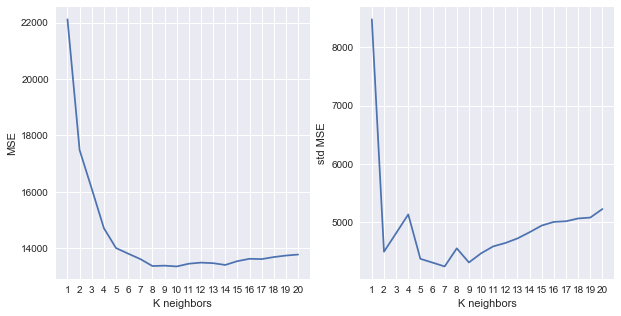

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig = plt.figure(figsize=(10,5))
fig.tight_layout()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(range(1,21),np.absolute(results))
ax1.set_xlabel("K neighbors")
ax1.set_ylabel("MSE")
ax1.set_xticks(range(1,21))

ax2.plot(range(1,21),results_std)
ax2.set_xlabel("K neighbors")
ax2.set_ylabel("std MSE")
ax2.set_xticks(range(1,21))

plt.show()

Exercise Start
==

**Description**

1. Study the [KNeighborRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) API and test new parameters in **hyperparameters** variable.

## 4.3. Bias-Variance Tradeoff

So far, we've been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. A model has two sources of error, **bias** and **variance**.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's **variance** while the average RMSE is a proxy for a model's **bias**. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.


<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1Ws58dUyjBEmDPzqZA6vRmShScFZxoeEV">



## 4.4 Make predictions on unseen data


In [55]:
from sklearn.metrics import mean_squared_error

# best model
best_knn = grid.best_estimator_

# predict using the best model with unseen X
predictions = best_knn.predict(test_X)

mse = mean_squared_error(test_y,predictions)

print("mse: {}\nrmse: {}".format(mse,np.sqrt(mse)))

mse: 10894.830489795919
rmse: 104.37830468922131
